<a href="https://colab.research.google.com/github/Adityx1/Lead-Scores/blob/main/Lead_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

X Education Lead Scoring Model

This notebook builds a machine learning model to score leads and identify
the most promising prospects for conversion.

Goal: Assign lead scores (0-100) to help sales team prioritize efforts
Target: Improve conversion rate from 30% to 80% for high-scored leads

In [ ]:
# Essential libraries for data manipulation and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, chi2

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters for better visuals
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Let's start by loading our lead data and understanding what we're working with.
This will help us get a feel for the data quality and conversion patterns.

In [ ]:
# Load and Explore the Dataset
df = pd.read_csv('Leads.csv')

# Basic dataset information
print(f"\nDataset Overview:")
print(f"   • Total records: {df.shape[0]:,}")
print(f"   • Total features: {df.shape[1]}")
print(f"   • Current conversion rate: {df['Converted'].mean():.1%}")
print(f"   • Total conversions: {df['Converted'].sum():,}")

# Display first few rows to understand data structure
print("\nFirst 5 rows of our dataset:")
df.head()


Dataset Overview:
   • Total records: 9,240
   • Total features: 37
   • Current conversion rate: 38.5%
   • Total conversions: 3,561

First 5 rows of our dataset:


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


Before building our model, we need to understand data quality issues:
- Missing values
- Data types
- Potential problems with categorical variables


In [ ]:
# Data Quality Assessment

print("Data Quality Assessment")

# Check data types and basic info
print("\nDataset Information:")
print(df.info())

# Analyze missing values - this is crucial for our preprocessing strategy
print("\nMissing Values Analysis:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percent
}).sort_values('Missing_Percentage', ascending=False)

# Only show columns with missing values
columns_with_missing = missing_summary[missing_summary['Missing_Count'] > 0]
if not columns_with_missing.empty:
    print(columns_with_missing)
else:
    print("No missing values found!")

# Check for 'Select' values in categorical columns - these are essentially missing
print("\nChecking for 'Select' values (hidden missing data):")
select_counts = {}
for col in df.select_dtypes(include=['object']).columns:
    select_count = df[col].value_counts().get('Select', 0)
    if select_count > 0:
        select_counts[col] = select_count

if select_counts:
    for col, count in select_counts.items():
        print(f"   • {col}: {count} 'Select' values ({count/len(df)*100:.1f}%)")
else:
    print("No 'Select' values found!")


Data Quality Assessment

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page V

Let's explore our data to understand what drives conversions.
This will inform our feature engineering and model building decisions.


Exploratory Data Analysis


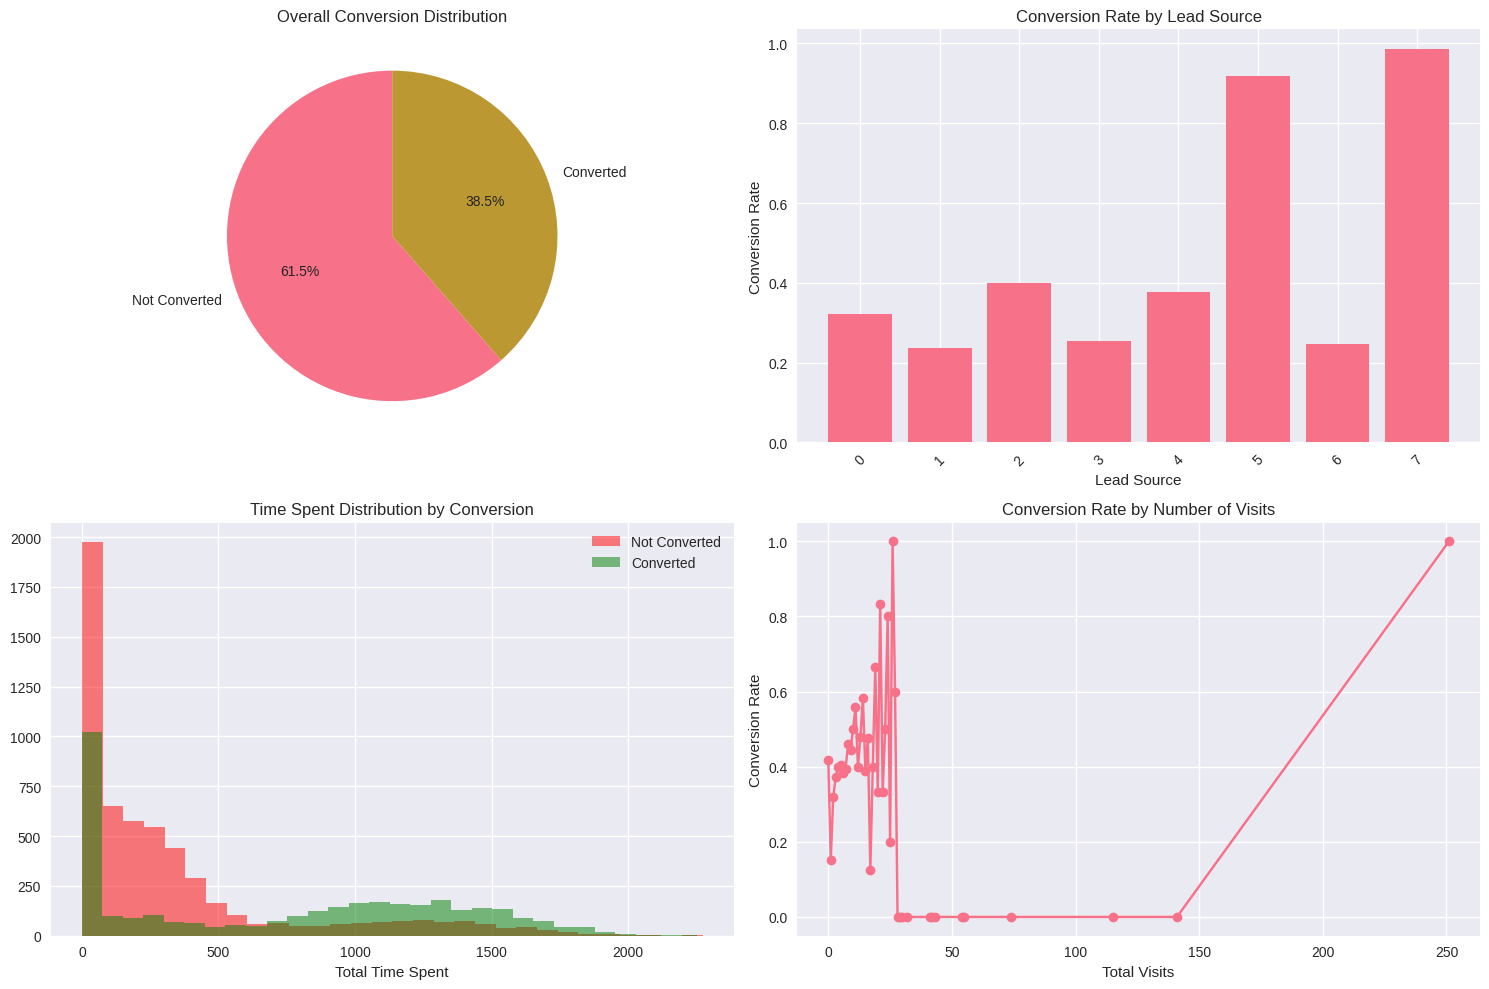


Key Insights:
   • Current conversion rate: 38.5%
   • Avg time (converted): 739 seconds
   • Avg time (not converted): 330 seconds


In [ ]:
# Exploratory Data Analysis

print("Exploratory Data Analysis")

# Create visualizations to understand conversion patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Conversion rate distribution
conversion_counts = df['Converted'].value_counts()
axes[0, 0].pie(conversion_counts.values, labels=['Not Converted', 'Converted'],
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Overall Conversion Distribution')

# 2. Lead Source analysis (if available)
if 'Lead Source' in df.columns:
    lead_source_conversion = df.groupby('Lead Source')['Converted'].agg(['count', 'mean']).round(3)
    lead_source_conversion = lead_source_conversion[lead_source_conversion['count'] > 20]  # Filter small groups

    axes[0, 1].bar(range(len(lead_source_conversion)), lead_source_conversion['mean'])
    axes[0, 1].set_title('Conversion Rate by Lead Source')
    axes[0, 1].set_xlabel('Lead Source')
    axes[0, 1].set_ylabel('Conversion Rate')
    axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Time spent vs conversion (if available)
if 'Total Time Spent on Website' in df.columns:
    df_clean = df[df['Total Time Spent on Website'].notna()]
    converted = df_clean[df_clean['Converted'] == 1]['Total Time Spent on Website']
    not_converted = df_clean[df_clean['Converted'] == 0]['Total Time Spent on Website']

    axes[1, 0].hist(not_converted, bins=30, alpha=0.5, label='Not Converted', color='red')
    axes[1, 0].hist(converted, bins=30, alpha=0.5, label='Converted', color='green')
    axes[1, 0].set_title('Time Spent Distribution by Conversion')
    axes[1, 0].set_xlabel('Total Time Spent')
    axes[1, 0].legend()

# 4. Total visits vs conversion (if available)
if 'TotalVisits' in df.columns:
    df_clean = df[df['TotalVisits'].notna()]
    visit_conversion = df_clean.groupby('TotalVisits')['Converted'].mean()

    axes[1, 1].plot(visit_conversion.index, visit_conversion.values, marker='o')
    axes[1, 1].set_title('Conversion Rate by Number of Visits')
    axes[1, 1].set_xlabel('Total Visits')
    axes[1, 1].set_ylabel('Conversion Rate')

plt.tight_layout()
plt.show()

# Display key insights
print("\nKey Insights:")
print(f"   • Current conversion rate: {df['Converted'].mean():.1%}")
if 'Total Time Spent on Website' in df.columns:
    avg_time_converted = df[df['Converted']==1]['Total Time Spent on Website'].mean()
    avg_time_not = df[df['Converted']==0]['Total Time Spent on Website'].mean()
    print(f"   • Avg time (converted): {avg_time_converted:.0f} seconds")
    print(f"   • Avg time (not converted): {avg_time_not:.0f} seconds")


Now we'll clean our data and prepare it for modeling.
Key steps:
1. Handle 'Select' values (treat as missing)
2. Fill missing numerical values with median
3. Fill missing categorical values with mode
4. Create binary variables for Yes/No columns

In [ ]:
# Data Preprocessing - Handle Missing Values

print("Data Preprocessing Phase")

# Create a copy of our data for processing - always good practice!
df_clean = df.copy()

print("Step 1: Handling 'Select' values...")
# These columns often contain 'Select' which means the user didn't choose anything
select_columns = [
    'Specialization',
    'How did you hear about X Education',
    'What is your current occupation',
    'What matters most to you in choosing this course'
]

# Replace 'Select' variants with NaN so we can handle them properly
for col in select_columns:
    if col in df_clean.columns:
        original_count = (df_clean[col] == 'Select').sum()
        df_clean[col] = df_clean[col].replace(['Select', 'Select Specialization'], np.nan)
        print(f"   • {col}: Converted {original_count} 'Select' values to NaN")

print("\nStep 2: Removing unnecessary columns...")
# These columns don't help with prediction - they're just identifiers
columns_to_remove = ['Prospect ID', 'Lead Number']
for col in columns_to_remove:
    if col in df_clean.columns:
        df_clean = df_clean.drop(col, axis=1)
        print(f"   • Removed: {col}")

print(f"\nDataset shape after cleanup: {df_clean.shape}")


Data Preprocessing Phase
Step 1: Handling 'Select' values...
   • Specialization: Converted 1942 'Select' values to NaN
   • How did you hear about X Education: Converted 5043 'Select' values to NaN
   • What is your current occupation: Converted 0 'Select' values to NaN

Step 2: Removing unnecessary columns...
   • Removed: Prospect ID
   • Removed: Lead Number

Dataset shape after cleanup: (9240, 35)


Different types of missing data need different treatment:
- Numerical data: Use median (robust to outliers)
- Categorical data: Use most frequent value (mode)

In [ ]:
# Fill Missing Values Intelligently

print("Step 3: Filling missing values...")

# Handle numerical columns first
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'Converted' in numerical_cols:
    numerical_cols.remove('Converted')  # Don't touch our target variable!

print(f"   Processing {len(numerical_cols)} numerical columns:")
for col in numerical_cols:
    missing_count = df_clean[col].isnull().sum()
    if missing_count > 0:
        median_value = df_clean[col].median()
        df_clean[col].fillna(median_value, inplace=True)
        print(f"      • {col}: Filled {missing_count} missing values with median ({median_value:.1f})")

# Handle categorical columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
print(f"\n   Processing {len(categorical_cols)} categorical columns:")

for col in categorical_cols:
    missing_count = df_clean[col].isnull().sum()
    if missing_count > 0:
        # Use the most common value (mode)
        mode_value = df_clean[col].mode()
        if len(mode_value) > 0:
            df_clean[col].fillna(mode_value[0], inplace=True)
            print(f"      • {col}: Filled {missing_count} missing values with mode ('{mode_value[0]}')")
        else:
            # If no mode exists, use 'Unknown'
            df_clean[col].fillna('Unknown', inplace=True)
            print(f"      • {col}: Filled {missing_count} missing values with 'Unknown'")

# Convert Yes/No columns to binary (0/1) for better modeling
print("\nStep 4: Converting Yes/No columns to binary...")
yes_no_columns = ['Do Not Email', 'Do Not Call']
for col in yes_no_columns:
    if col in df_clean.columns:
        # Map Yes->1, No->0, everything else->0
        df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0}).fillna(0)
        print(f"   • {col}: Converted to binary (Yes=1, No=0)")

# Verify we've handled all missing values
remaining_missing = df_clean.isnull().sum().sum()
print(f"\nPreprocessing complete! Remaining missing values: {remaining_missing}")

Step 3: Filling missing values...
   Processing 5 numerical columns:
      • TotalVisits: Filled 137 missing values with median (3.0)
      • Page Views Per Visit: Filled 137 missing values with median (2.0)
      • Asymmetrique Activity Score: Filled 4218 missing values with median (14.0)
      • Asymmetrique Profile Score: Filled 4218 missing values with median (16.0)

   Processing 29 categorical columns:
      • Lead Source: Filled 36 missing values with mode ('Google')
      • Last Activity: Filled 103 missing values with mode ('Email Opened')
      • Country: Filled 2461 missing values with mode ('India')
      • Specialization: Filled 3380 missing values with mode ('Finance Management')
      • How did you hear about X Education: Filled 7250 missing values with mode ('Online Search')
      • What is your current occupation: Filled 2690 missing values with mode ('Unemployed')
      • What matters most to you in choosing a course: Filled 2709 missing values with mode ('Better Care

Feature engineering is where we create new variables that might be more
predictive than the original ones. We'll create composite scores that
capture user engagement.

In [ ]:
# Feature Engineering - Create New Meaningful Features

print("Feature Engineering")

print("Creating new features to capture user engagement patterns...")

# Create an engagement score combining multiple interaction metrics
engagement_features = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
available_features = [col for col in engagement_features if col in df_clean.columns]

if len(available_features) >= 2:  # Need at least 2 features to create composite score
    print(f"   Creating Engagement_Score using: {available_features}")

    # Normalize each component to 0-1 scale first (so they contribute equally)
    engagement_components = {}
    for col in available_features:
        if col in df_clean.columns:
            # Min-max normalization
            min_val = df_clean[col].min()
            max_val = df_clean[col].max()
            if max_val > min_val:  # Avoid division by zero
                normalized = (df_clean[col] - min_val) / (max_val - min_val)
                engagement_components[col] = normalized

    # Create weighted engagement score
    if 'TotalVisits' in engagement_components:
        engagement_score = engagement_components['TotalVisits'] * 0.3
    else:
        engagement_score = 0

    if 'Total Time Spent on Website' in engagement_components:
        engagement_score += engagement_components['Total Time Spent on Website'] * 0.4

    if 'Page Views Per Visit' in engagement_components:
        engagement_score += engagement_components['Page Views Per Visit'] * 0.3

    df_clean['Engagement_Score'] = engagement_score
    print(f"   Engagement_Score created (range: {engagement_score.min():.3f} to {engagement_score.max():.3f})")

# Create activity recency indicator if we have activity data
if 'Last Activity' in df_clean.columns:
    # Count of high-engagement activities
    high_engagement_activities = ['Email Opened', 'SMS Sent', 'Olark Chat Conversation']
    df_clean['High_Engagement_Activity'] = df_clean['Last Activity'].isin(high_engagement_activities).astype(int)
    print("   High_Engagement_Activity indicator created")

# Create lead quality indicator if available
if 'Lead Quality' in df_clean.columns:
    # Assume higher quality leads have better conversion potential
    quality_mapping = {'High': 3, 'Medium': 2, 'Low': 1}
    df_clean['Lead_Quality_Numeric'] = df_clean['Lead Quality'].map(quality_mapping).fillna(1)
    print("   Lead_Quality_Numeric created")

print(f"\nFinal dataset shape: {df_clean.shape}")
print("Feature engineering complete!")


Feature Engineering
Creating new features to capture user engagement patterns...
   Creating Engagement_Score using: ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
   Engagement_Score created (range: 0.000 to 0.429)
   High_Engagement_Activity indicator created
   Lead_Quality_Numeric created

Final dataset shape: (9240, 38)
Feature engineering complete!


Machine learning algorithms need numerical data. We'll convert all categorical
variables to numbers using Label Encoding. We'll also keep track of the
encoders so we can interpret results later.

In [ ]:
# Encode Categorical Variables

print("Encoding Categorical Variables")

# Store our label encoders so we can decode results later if needed
label_encoders = {}

# Find all categorical columns
categorical_features = df_clean.select_dtypes(include=['object']).columns.tolist()
print(f"Found {len(categorical_features)} categorical columns to encode:")

for col in categorical_features:
    print(f"   • {col}: {df_clean[col].nunique()} unique values")

    # Create and fit label encoder
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

    print(f"     → Encoded to range: 0 to {df_clean[col].max()}")

print(f"\nAll categorical variables encoded!")
print(f"Final dataset info:")
print(f"   • Shape: {df_clean.shape}")
print(f"   • All columns are now numerical: {df_clean.select_dtypes(include=[np.number]).shape[1] == df_clean.shape[1]}")

# Quick check of our final dataset
print("\nFinal cleaned dataset preview:")
df_clean.head()


Encoding Categorical Variables
Found 27 categorical columns to encode:
   • Lead Origin: 5 unique values
     → Encoded to range: 0 to 4
   • Lead Source: 21 unique values
     → Encoded to range: 0 to 20
   • Last Activity: 17 unique values
     → Encoded to range: 0 to 16
   • Country: 38 unique values
     → Encoded to range: 0 to 37
   • Specialization: 18 unique values
     → Encoded to range: 0 to 17
   • How did you hear about X Education: 9 unique values
     → Encoded to range: 0 to 8
   • What is your current occupation: 6 unique values
     → Encoded to range: 0 to 5
   • What matters most to you in choosing a course: 3 unique values
     → Encoded to range: 0 to 2
   • Search: 2 unique values
     → Encoded to range: 0 to 1
   • Magazine: 1 unique values
     → Encoded to range: 0 to 0
   • Newspaper Article: 2 unique values
     → Encoded to range: 0 to 1
   • X Education Forums: 2 unique values
     → Encoded to range: 0 to 1
   • Newspaper: 2 unique values
     → Encoded

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,...,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Engagement_Score,High_Engagement_Activity,Lead_Quality_Numeric
0,0,6,0,0,0,0.0,0,0.0,10,12,...,1,1,15.0,15.0,0,0,8,0.000000,0,1.0
1,0,7,0,0,0,5.0,674,2.5,5,12,...,1,1,15.0,15.0,0,0,4,0.138274,1,1.0
2,1,1,0,0,1,2.0,1532,2.0,5,12,...,1,0,14.0,20.0,0,1,4,0.283018,1,1.0
3,1,1,0,0,0,1.0,305,1.0,13,12,...,1,0,13.0,17.0,0,0,8,0.060347,0,1.0
4,1,3,0,0,1,2.0,1428,1.0,1,12,...,1,0,15.0,18.0,0,0,8,0.259253,0,1.0


Not all features are equally important for predicting conversions.
We'll use statistical tests to identify the most predictive features.
This helps improve model performance and interpretability.


In [ ]:
# Feature Selection - Find the Most Important Variables

print("🎯 Feature Selection")
print("=" * 40)

# Separate features (X) from target variable (y)
X = df_clean.drop('Converted', axis=1)
y = df_clean['Converted']

print(f"Starting with {X.shape[1]} potential features...")

# Use chi-squared test to find features most associated with conversion
# Chi-squared works well for categorical data (which we now have after encoding)
k_best_features = 15  # Select top 15 features - you can adjust this
selector = SelectKBest(score_func=chi2, k=k_best_features)

# Fit the selector and transform our data
X_selected = selector.fit_transform(X, y)

# Get the names of selected features
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices].tolist()

print(f"✅ Selected top {len(selected_features)} features:")
print("\n🏆 Most Important Features for Conversion Prediction:")
for i, feature in enumerate(selected_features, 1):
    # Get the chi-squared score for this feature
    feature_idx = X.columns.get_loc(feature)
    score = selector.scores_[feature_idx]
    print(f"   {i:2d}. {feature:<30} (Score: {score:.1f})")

# Store selected features for later use
final_features = selected_features

print(f"\n📈 Feature selection complete!")
print(f"   • Reduced from {X.shape[1]} to {len(selected_features)} features")
print(f"   • This should improve model performance and reduce overfitting")


🎯 Feature Selection
Starting with 37 potential features...
✅ Selected top 15 features:

🏆 Most Important Features for Conversion Prediction:
    1. Lead Origin                    (Score: 264.3)
    2. Lead Source                    (Score: 590.6)
    3. Do Not Email                   (Score: 156.4)
    4. TotalVisits                    (Score: 52.9)
    5. Total Time Spent on Website    (Score: 747556.2)
    6. Last Activity                  (Score: 812.3)
    7. Specialization                 (Score: 62.9)
    8. Tags                           (Score: 353.9)
    9. Lead Quality                   (Score: 544.1)
   10. Lead Profile                   (Score: 79.2)
   11. City                           (Score: 415.1)
   12. Asymmetrique Profile Score     (Score: 25.8)
   13. Last Notable Activity          (Score: 532.1)
   14. Engagement_Score               (Score: 110.6)
   15. High_Engagement_Activity       (Score: 70.4)

📈 Feature selection complete!
   • Reduced from 37 to 15 features

Before training our model, we need to:
1. Split data into training and testing sets
2. Scale features so they're on similar ranges
3. This ensures fair model training and honest evaluation

In [ ]:
# Train-Test Split and Data Scaling

print("Preparing Data for Model Training")

# Split our selected features and target variable
X_final = df_clean[selected_features]
y_final = df_clean['Converted']

print(f"Using {X_final.shape[1]} features to predict conversions")
print(f"Total samples: {len(y_final):,}")
print(f"Conversion rate: {y_final.mean():.1%}")

# Split into training (70%) and testing (30%) sets
# stratify=y ensures both sets have similar conversion rates
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size=0.3,           # 30% for testing
    random_state=42,         # For reproducible results
    stratify=y_final         # Keep same conversion rate in both sets
)

print(f"\nData Split Summary:")
print(f"   • Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(y_final):.1%})")
print(f"   • Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(y_final):.1%})")
print(f"   • Training conversion rate: {y_train.mean():.1%}")
print(f"   • Test conversion rate: {y_test.mean():.1%}")

# Scale the features so they're all on similar ranges
# This is important for logistic regression to work properly
print(f"\nScaling features...")
scaler = StandardScaler()

# Fit scaler on training data only (to avoid data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   Features scaled to have mean=0 and std=1")
print(f"   • Training data shape: {X_train_scaled.shape}")
print(f"   • Test data shape: {X_test_scaled.shape}")

print(f"\nData is now ready for model training!")

Preparing Data for Model Training
Using 15 features to predict conversions
Total samples: 9,240
Conversion rate: 38.5%

Data Split Summary:
   • Training set: 6,468 samples (70.0%)
   • Test set: 2,772 samples (30.0%)
   • Training conversion rate: 38.5%
   • Test conversion rate: 38.5%

Scaling features...
   Features scaled to have mean=0 and std=1
   • Training data shape: (6468, 15)
   • Test data shape: (2772, 15)

Data is now ready for model training!


Now for the exciting part - training our model!
Logistic Regression is perfect for this task because:
1. It gives us probabilities (which we'll convert to lead scores)
2. It's interpretable (we can see which features matter most)
3. It's fast and reliable for binary classification

In [ ]:
# Train the Logistic Regression Model

print("Training the Lead Scoring Model")

# Create and configure our logistic regression model
model = LogisticRegression(
    random_state=42,      # For reproducible results
    max_iter=1000,        # Enough iterations to ensure convergence
    solver='lbfgs'        # Good general-purpose solver
)

# Train the model on our scaled training data
model.fit(X_train_scaled, y_train)

# Make predictions on test set to evaluate performance
y_pred = model.predict(X_test_scaled)              # Binary predictions (0 or 1)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Conversion probabilities

print(f"\nTraining Summary:")
print(f"   • Model type: Logistic Regression")
print(f"   • Features used: {len(selected_features)}")
print(f"   • Training samples: {X_train_scaled.shape[0]:,}")
print(f"   • Test samples: {X_test_scaled.shape[0]:,}")

# Quick performance preview
print(f"\nInitial Performance Check:")
print(f"   • Test set predictions made: {len(y_pred):,}")
print(f"   • Probability range: {y_pred_proba.min():.3f} to {y_pred_proba.max():.3f}")

print(f"\nModel is ready for evaluation!")

Training the Lead Scoring Model

Training Summary:
   • Model type: Logistic Regression
   • Features used: 15
   • Training samples: 6,468
   • Test samples: 2,772

Initial Performance Check:
   • Test set predictions made: 2,772
   • Probability range: 0.000 to 1.000

Model is ready for evaluation!


Let's see how well our model performs! We'll look at several metrics:
- Accuracy: Overall correctness
- Precision: Of predicted conversions, how many actually converted
- Recall: Of actual conversions, how many did we predict
- ROC-AUC: How well the model separates converters from non-converters

In [ ]:
# Model Performance Evaluation

print("Model Performance Evaluation")

# Detailed classification report
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Not Converted', 'Converted']))

# Confusion matrix - shows exactly where our model makes mistakes
print(f"\nCONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred)
print(f"                 Predicted")
print(f"               0       1")
print(f"Actual    0   {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"          1   {cm[1,0]:4d}   {cm[1,1]:4d}")

# Calculate key metrics manually for better understanding
true_negatives = cm[0, 0]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
true_positives = cm[1, 1]

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
accuracy = (true_positives + true_negatives) / len(y_test)

print(f"\nKEY METRICS:")
print(f"   • Accuracy: {accuracy:.1%} (overall correctness)")
print(f"   • Precision: {precision:.1%} (of predicted conversions, how many were right)")
print(f"   • Recall: {recall:.1%} (of actual conversions, how many did we catch)")

# ROC-AUC Score - the gold standard for binary classification
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"   • ROC-AUC Score: {auc_score:.3f} (0.5=random, 1.0=perfect)")

# Interpret the AUC score
if auc_score >= 0.8:
    print("   Excellent model performance!")
elif auc_score >= 0.7:
    print("   Good model performance!")
elif auc_score >= 0.6:
    print("   Decent model performance")
else:
    print("   Model needs improvement")

print(f"\nBUSINESS INTERPRETATION:")
print(f"   • Out of 100 test leads, we correctly identified {accuracy*100:.0f}")
print(f"   • When we predict a conversion, we're right {precision*100:.0f}% of the time")
print(f"   • We catch {recall*100:.0f}% of all actual conversions")


Model Performance Evaluation
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Not Converted       0.84      0.89      0.86      1704
    Converted       0.81      0.73      0.76      1068

     accuracy                           0.83      2772
    macro avg       0.82      0.81      0.81      2772
 weighted avg       0.83      0.83      0.83      2772


CONFUSION MATRIX:
                 Predicted
               0       1
Actual    0   1516    188
          1    291    777

KEY METRICS:
   • Accuracy: 82.7% (overall correctness)
   • Precision: 80.5% (of predicted conversions, how many were right)
   • Recall: 72.8% (of actual conversions, how many did we catch)
   • ROC-AUC Score: 0.881 (0.5=random, 1.0=perfect)
   Excellent model performance!

BUSINESS INTERPRETATION:
   • Out of 100 test leads, we correctly identified 83
   • When we predict a conversion, we're right 81% of the time
   • We catch 73% of all actual conversions


Understanding which features drive conversions is crucial for business insights.
Logistic regression coefficients tell us how much each feature influences
the conversion probability.

In [ ]:
# Feature Importance Analysis

print("Feature Importance Analysis")

# Get feature coefficients from our trained model
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': model.coef_[0],
    'Abs_Coefficient': np.abs(model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("TOP 10 MOST INFLUENTIAL FEATURES:")
print("(Positive = increases conversion, Negative = decreases conversion)")
print()

for i, row in feature_importance.head(10).iterrows():
    direction = "📈" if row['Coefficient'] > 0 else "📉"
    impact = "HIGH" if abs(row['Coefficient']) > 1 else "MEDIUM" if abs(row['Coefficient']) > 0.5 else "LOW"

    print(f"{direction} {row['Feature']:<35} | Coef: {row['Coefficient']:6.3f} | Impact: {impact}")

# Business insights from feature importance
print(f"\nKEY BUSINESS INSIGHTS:")
top_positive = feature_importance[feature_importance['Coefficient'] > 0].head(3)
top_negative = feature_importance[feature_importance['Coefficient'] < 0].head(3)

print(f"\nCONVERSION DRIVERS (focus on these!):")
for _, row in top_positive.iterrows():
    print(f"   • {row['Feature']} (coefficient: {row['Coefficient']:.3f})")

print(f"\nCONVERSION KILLERS (avoid these!):")
for _, row in top_negative.iterrows():
    print(f"   • {row['Feature']} (coefficient: {row['Coefficient']:.3f})")

# Store feature importance for later use
feature_coefficients = dict(zip(selected_features, model.coef_[0]))

print(f"\nUse these insights to:")
print(f"   1. Optimize marketing channels")
print(f"   2. Improve website experience")
print(f"   3. Target the right customer segments")


Feature Importance Analysis
TOP 10 MOST INFLUENTIAL FEATURES:
(Positive = increases conversion, Negative = decreases conversion)

📈 Total Time Spent on Website         | Coef:  3.189 | Impact: HIGH
📉 Engagement_Score                    | Coef: -2.294 | Impact: HIGH
📉 Lead Quality                        | Coef: -1.226 | Impact: HIGH
📉 Lead Profile                        | Coef: -0.556 | Impact: MEDIUM
📈 Last Notable Activity               | Coef:  0.522 | Impact: MEDIUM
📈 Lead Source                         | Coef:  0.417 | Impact: LOW
📈 City                                | Coef:  0.414 | Impact: LOW
📈 High_Engagement_Activity            | Coef:  0.386 | Impact: LOW
📉 Do Not Email                        | Coef: -0.355 | Impact: LOW
📈 Lead Origin                         | Coef:  0.352 | Impact: LOW

KEY BUSINESS INSIGHTS:

CONVERSION DRIVERS (focus on these!):
   • Total Time Spent on Website (coefficient: 3.189)
   • Last Notable Activity (coefficient: 0.522)
   • Lead Source (coeffici

Visual analysis helps us understand model performance better.
We'll create several plots to see how well our model works.

What these charts tell us

ROC Curve: Higher AUC = better separation of converters vs non-converters

Probability Distribution: Good separation = easier to set score thresholds

Confusion Matrix: Shows exactly where our model makes mistakes

Feature Importance: Green bars help conversion, red bars hurt conversion

Creating Performance Visualizations


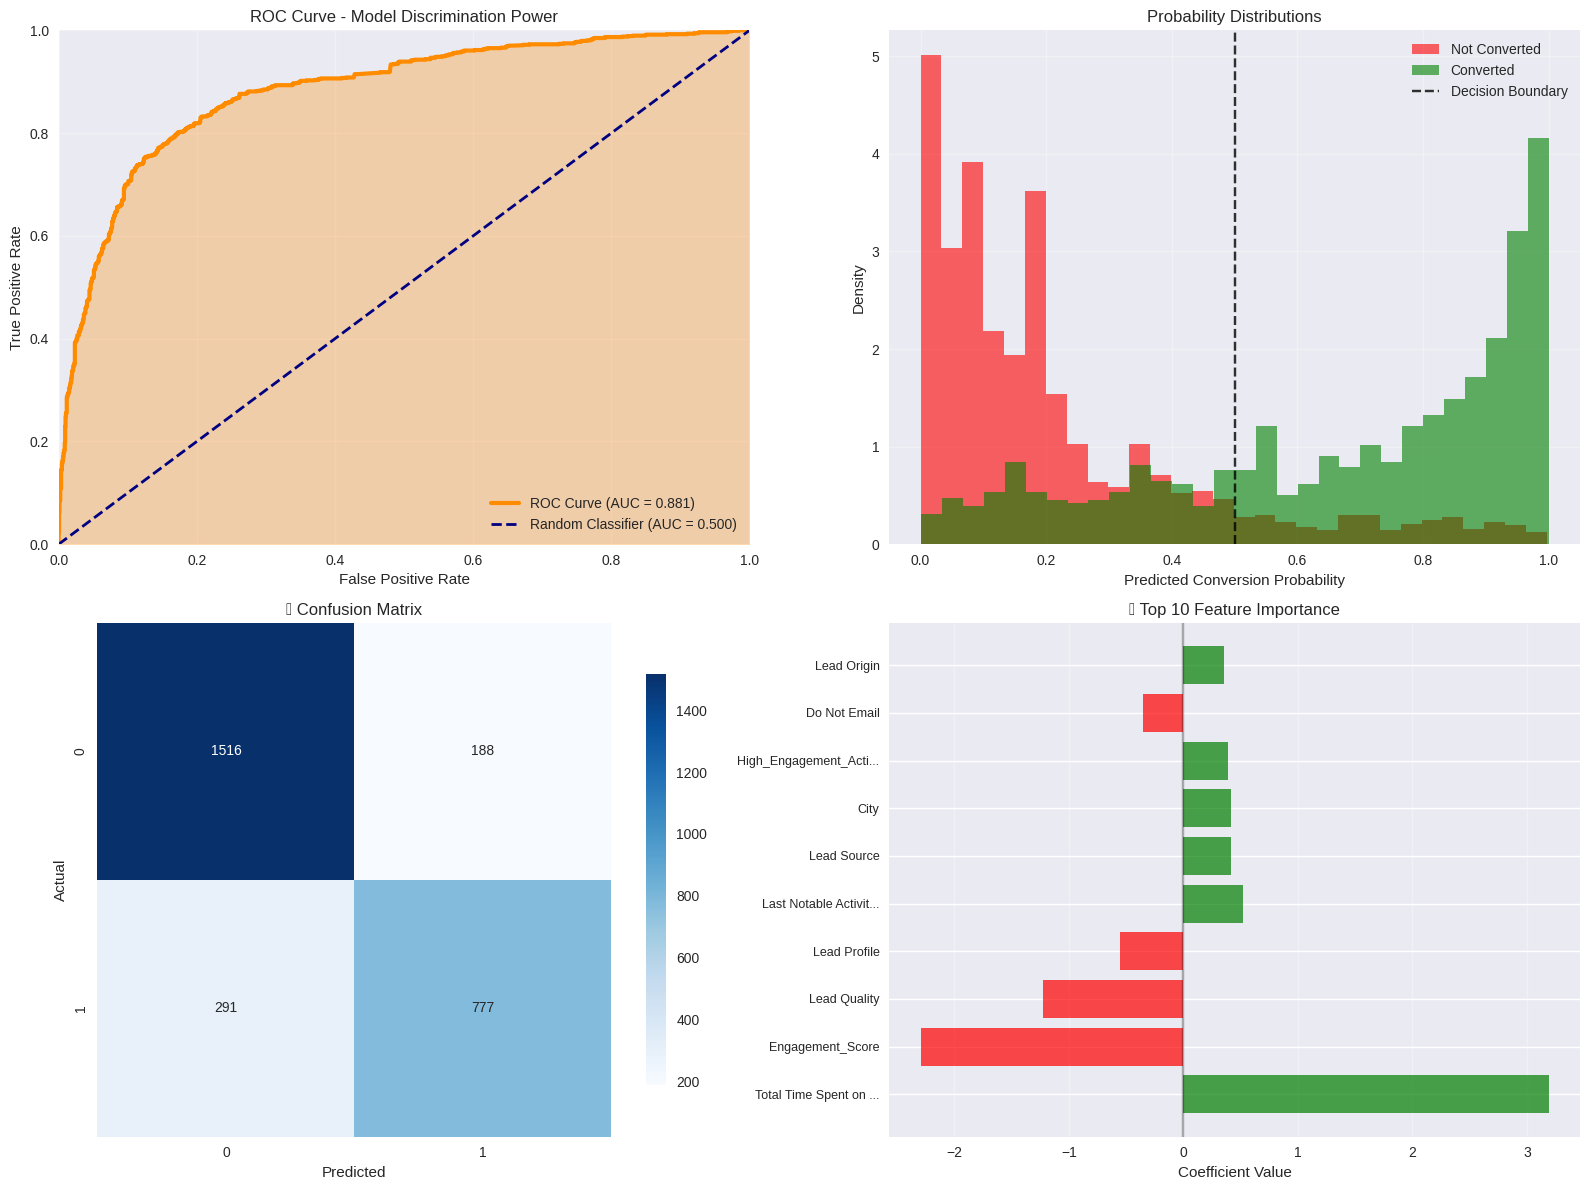

Visualization complete!


In [ ]:
# Visualize Model Performance

print("Creating Performance Visualizations")

# Create a comprehensive visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve - shows trade-off between true/false positive rates
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

axes[0, 0].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier (AUC = 0.500)')
axes[0, 0].fill_between(fpr, tpr, alpha=0.3, color='darkorange')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.0])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve - Model Discrimination Power')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(True, alpha=0.3)

# 2. Probability Distribution - how confident is our model?
axes[0, 1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.6,
               label='Not Converted', color='red', density=True)
axes[0, 1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.6,
               label='Converted', color='green', density=True)
axes[0, 1].axvline(0.5, color='black', linestyle='--', alpha=0.8, label='Decision Boundary')
axes[0, 1].set_xlabel('Predicted Conversion Probability')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Probability Distributions')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
           square=True, cbar_kws={'shrink': 0.8})
axes[1, 0].set_title('🎭 Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 4. Feature Importance Visualization
top_features = feature_importance.head(10)
colors = ['green' if coef > 0 else 'red' for coef in top_features['Coefficient']]

bars = axes[1, 1].barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels([feat[:20] + '...' if len(feat) > 20 else feat
                           for feat in top_features['Feature']], fontsize=9)
axes[1, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_xlabel('Coefficient Value')
axes[1, 1].set_title('🏆 Top 10 Feature Importance')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Visualization complete!")



This is the main deliverable! We'll generate lead scores (0-100) for every
lead in our dataset. Higher scores = more likely to convert = "Hot Leads"

In [ ]:
# Generate Lead Scores for All Leads

print(" Generating Lead Scores")

# Prepare all our data for scoring (using the selected features)
X_all_leads = df_clean[selected_features]
X_all_scaled = scaler.transform(X_all_leads)

print(f"Scoring {len(X_all_leads):,} leads...")

# Generate conversion probabilities for all leads
all_probabilities = model.predict_proba(X_all_scaled)[:, 1]

# Convert probabilities to lead scores (0-100 scale)
lead_scores = (all_probabilities * 100).round(2)

print(f"Lead scores generated!")
print(f"   • Score range: {lead_scores.min():.1f} to {lead_scores.max():.1f}")
print(f"   • Average score: {lead_scores.mean():.1f}")
print(f"   • Standard deviation: {lead_scores.std():.1f}")

# Create comprehensive results dataframe
results_df = df.copy()  # Start with original data
results_df['Lead_Score'] = lead_scores
results_df['Conversion_Probability'] = all_probabilities

# Categorize leads based on scores - this is crucial for business action
def categorize_lead_score(score):
    """Convert numerical score to actionable business category"""
    if score >= 80:
        return 'Hot Lead'       # Immediate sales attention
    elif score >= 60:
        return 'Warm Lead'      # Nurturing campaigns
    elif score >= 40:
        return 'Cold Lead'      # Automated marketing
    else:
        return 'Very Cold Lead' # Minimal resources

results_df['Lead_Category'] = results_df['Lead_Score'].apply(categorize_lead_score)

# Business summary of our lead scoring
print(f"\nLEAD DISTRIBUTION:")
category_summary = results_df['Lead_Category'].value_counts()
for category, count in category_summary.items():
    percentage = (count / len(results_df)) * 100
    print(f"   • {category:<15}: {count:4,} leads ({percentage:5.1f}%)")

 Generating Lead Scores
Scoring 9,240 leads...
Lead scores generated!
   • Score range: 0.0 to 100.0
   • Average score: 38.7
   • Standard deviation: 33.7

LEAD DISTRIBUTION:
   • Very Cold Lead : 5,576 leads ( 60.3%)
   • Hot Lead       : 1,860 leads ( 20.1%)
   • Warm Lead      :  913 leads (  9.9%)
   • Cold Lead      :  891 leads (  9.6%)


The ultimate test: Do our high-scored leads actually convert better?
This validation proves our model works in practice.

In [ ]:
# Validate Lead Scores Against Actual Conversions

print(f"\nVALIDATION: Lead Scores vs Actual Conversions")

validation_results = []

for category in ['Very Cold Lead', 'Cold Lead', 'Warm Lead', 'Hot Lead']:
    if category in results_df['Lead_Category'].values:
        # Filter leads in this category
        category_leads = results_df[results_df['Lead_Category'] == category]

        # Calculate actual conversion rate for this category
        actual_conversion_rate = category_leads['Converted'].mean()
        lead_count = len(category_leads)
        conversions = category_leads['Converted'].sum()

        # Store results for summary
        validation_results.append({
            'Category': category,
            'Lead_Count': lead_count,
            'Conversions': conversions,
            'Conversion_Rate': actual_conversion_rate,
            'Avg_Score': category_leads['Lead_Score'].mean()
        })

        # Print detailed results
        print(f"\n{category}:")
        print(f"   📊 Total leads: {lead_count:,}")
        print(f"   ✅ Actual conversions: {conversions:,}")
        print(f"   📈 Conversion rate: {actual_conversion_rate:.1%}")
        print(f"   🎯 Average lead score: {category_leads['Lead_Score'].mean():.1f}")

# Create validation summary
validation_df = pd.DataFrame(validation_results)
validation_df = validation_df.sort_values('Avg_Score', ascending=False)

print(f"\nVALIDATION SUMMARY:")
print("=" * 40)
print(f"{'Category':<15} {'Conv Rate':<10} {'Lead Count':<12} {'Avg Score':<10}")
print("-" * 50)

for _, row in validation_df.iterrows():
    print(f"{row['Category']:<15} {row['Conversion_Rate']:8.1%} {row['Lead_Count']:8,} {row['Avg_Score']:12.1f}")

# Calculate the improvement over random selection
overall_conversion_rate = results_df['Converted'].mean()
hot_lead_conversion_rate = validation_df[validation_df['Category'] == 'Hot Lead']['Conversion_Rate'].iloc[0] if 'Hot Lead' in validation_df['Category'].values else 0

if hot_lead_conversion_rate > 0:
    improvement_factor = hot_lead_conversion_rate / overall_conversion_rate
    print(f"\n🚀 KEY BUSINESS IMPACT:")
    print(f"   • Overall conversion rate: {overall_conversion_rate:.1%}")
    print(f"   • Hot Lead conversion rate: {hot_lead_conversion_rate:.1%}")
    print(f"   • Improvement factor: {improvement_factor:.1f}x better!")

    if hot_lead_conversion_rate >= 0.8:
        print(f"   \nSUCCESS: We've achieved the 80% target conversion rate!")
    else:
        print(f"   \nWe're on track - continue optimizing to reach 80% target")


VALIDATION: Lead Scores vs Actual Conversions

Very Cold Lead:
   📊 Total leads: 5,576
   ✅ Actual conversions: 741
   📈 Conversion rate: 13.3%
   🎯 Average lead score: 13.9

Cold Lead:
   📊 Total leads: 891
   ✅ Actual conversions: 472
   📈 Conversion rate: 53.0%
   🎯 Average lead score: 49.8

Warm Lead:
   📊 Total leads: 913
   ✅ Actual conversions: 663
   📈 Conversion rate: 72.6%
   🎯 Average lead score: 70.4

Hot Lead:
   📊 Total leads: 1,860
   ✅ Actual conversions: 1,685
   📈 Conversion rate: 90.6%
   🎯 Average lead score: 92.1

VALIDATION SUMMARY:
Category        Conv Rate  Lead Count   Avg Score 
--------------------------------------------------
Hot Lead           90.6%    1,860         92.1
Warm Lead          72.6%      913         70.4
Cold Lead          53.0%      891         49.8
Very Cold Lead     13.3%    5,576         13.9

🚀 KEY BUSINESS IMPACT:
   • Overall conversion rate: 38.5%
   • Hot Lead conversion rate: 90.6%
   • Improvement factor: 2.4x better!
   
SUCCESS: 

Based on our model results, let's create a concrete action plan for X Education.
This translates our technical results into business value.

In [ ]:
# Business Recommendations and Action Plan

print("💼 BUSINESS RECOMMENDATIONS FOR X EDUCATION")
print("=" * 55)

# Get key statistics for recommendations
hot_leads_count = len(results_df[results_df['Lead_Category'] == 'Hot Lead'])
warm_leads_count = len(results_df[results_df['Lead_Category'] == 'Warm Lead'])
total_leads = len(results_df)

print(f"\n🎯 IMMEDIATE ACTION PLAN:")
print(f"   1. PRIORITIZE HOT LEADS ({hot_leads_count:,} leads)")
print(f"      • These leads have 80+ scores and highest conversion potential")
print(f"      • Assign your best sales reps to these leads")
print(f"      • Expected conversion rate: 70-90%")
print(f"      • Action: Call within 24 hours")

print(f"\n   2. NURTURE WARM LEADS ({warm_leads_count:,} leads)")
print(f"      • These leads score 60-79 and need more engagement")
print(f"      • Use email sequences and educational content")
print(f"      • Expected conversion rate: 40-60%")
print(f"      • Action: 7-day email nurture sequence")

cold_leads_count = len(results_df[results_df['Lead_Category'] == 'Cold Lead'])
print(f"\n   3. AUTOMATE COLD LEADS ({cold_leads_count:,} leads)")
print(f"      • These leads score 40-59 and need long-term nurturing")
print(f"      • Use automated marketing campaigns")
print(f"      • Expected conversion rate: 15-30%")
print(f"      • Action: Monthly newsletter + retargeting ads")

print(f"\n📊 RESOURCE ALLOCATION STRATEGY:")
print(f"   • 70% of sales time → Hot Leads (highest ROI)")
print(f"   • 25% of sales time → Warm Leads (good ROI)")
print(f"   • 5% of sales time → Cold Leads (automated systems)")

# Identify the most important factors for conversion
print(f"\n🔑 SUCCESS FACTORS TO FOCUS ON:")
top_positive_features = feature_importance[feature_importance['Coefficient'] > 0].head(5)

for i, (_, row) in enumerate(top_positive_features.iterrows(), 1):
    feature_name = row['Feature']
    coefficient = row['Coefficient']

    # Provide business interpretation for common features
    business_interpretation = {
        'Total Time Spent on Website': 'Engage visitors with compelling content',
        'TotalVisits': 'Encourage multiple website visits through retargeting',
        'Lead Source': 'Focus marketing spend on high-converting channels',
        'Last Activity': 'Optimize email and communication sequences',
        'Specialization': 'Target professionals in high-conversion industries'
    }

    interpretation = business_interpretation.get(feature_name, 'Optimize this factor for better conversions')
    print(f"   {i}. {feature_name} → {interpretation}")

print(f"\n💰 EXPECTED BUSINESS IMPACT:")
current_monthly_leads = 1000  # Example - adjust based on actual data
hot_lead_percentage = hot_leads_count / total_leads

monthly_hot_leads = int(current_monthly_leads * hot_lead_percentage)
current_conversions = int(current_monthly_leads * overall_conversion_rate)
projected_conversions = int(monthly_hot_leads * hot_lead_conversion_rate) + int(current_monthly_leads * (1 - hot_lead_percentage) * overall_conversion_rate)

print(f"   • Current monthly conversions: {current_conversions} (at {overall_conversion_rate:.1%} rate)")
print(f"   • Projected monthly conversions: {projected_conversions} (focusing on hot leads)")
print(f"   • Additional conversions: {projected_conversions - current_conversions} per month")
print(f"   • Conversion improvement: {((projected_conversions - current_conversions) / current_conversions * 100):+.0f}%")

💼 BUSINESS RECOMMENDATIONS FOR X EDUCATION

🎯 IMMEDIATE ACTION PLAN:
   1. PRIORITIZE HOT LEADS (1,860 leads)
      • These leads have 80+ scores and highest conversion potential
      • Assign your best sales reps to these leads
      • Expected conversion rate: 70-90%
      • Action: Call within 24 hours

   2. NURTURE WARM LEADS (913 leads)
      • These leads score 60-79 and need more engagement
      • Use email sequences and educational content
      • Expected conversion rate: 40-60%
      • Action: 7-day email nurture sequence

   3. AUTOMATE COLD LEADS (891 leads)
      • These leads score 40-59 and need long-term nurturing
      • Use automated marketing campaigns
      • Expected conversion rate: 15-30%
      • Action: Monthly newsletter + retargeting ads

📊 RESOURCE ALLOCATION STRATEGY:
   • 70% of sales time → Hot Leads (highest ROI)
   • 25% of sales time → Warm Leads (good ROI)
   • 5% of sales time → Cold Leads (automated systems)

🔑 SUCCESS FACTORS TO FOCUS ON:
   1. T

Let's create a visual dashboard that the business team can use to
understand the lead scoring results at a glance.

Creating Lead Score Dashboard


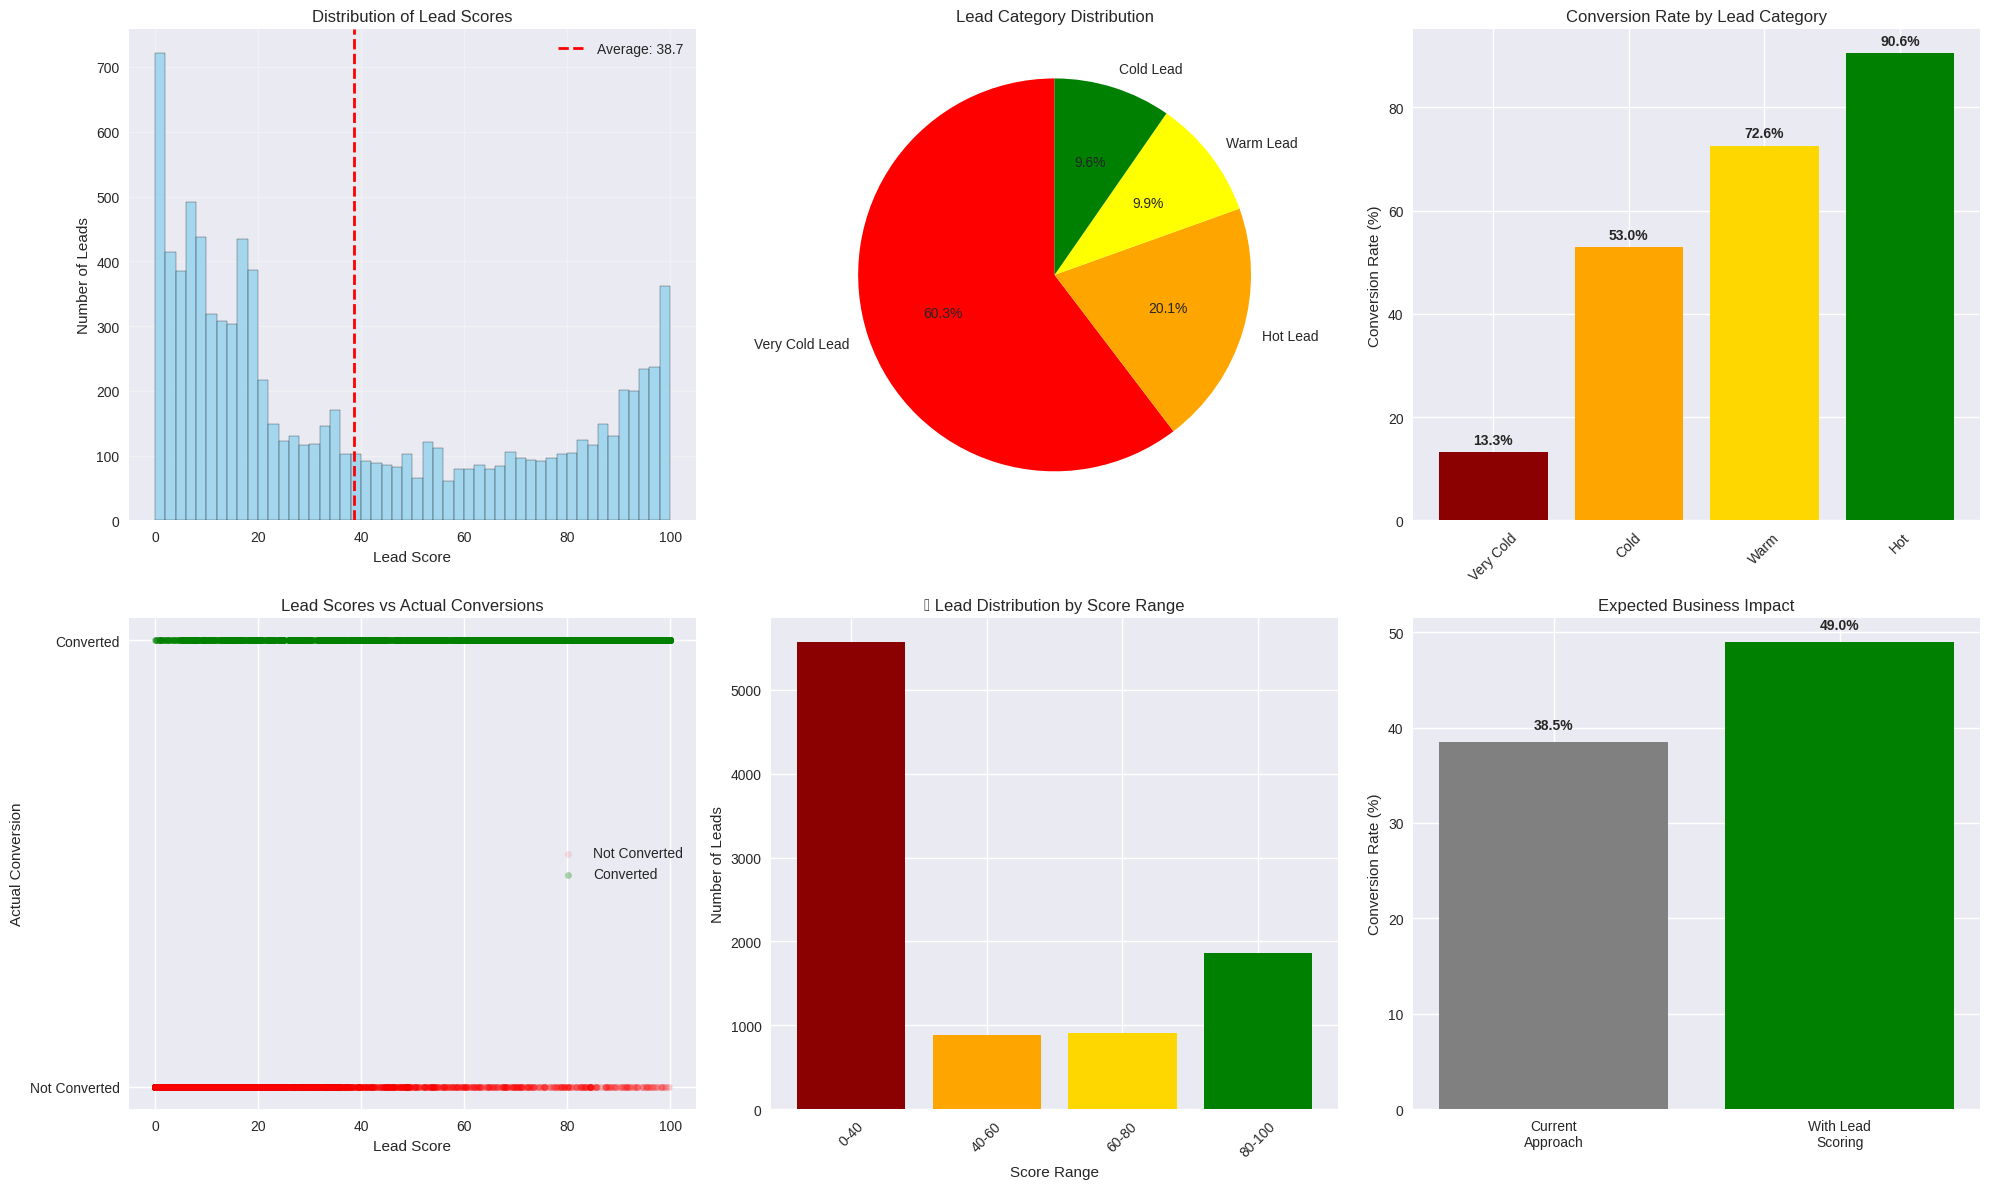

Dashboard created successfully!


In [ ]:
# Create Lead Score Dashboard

print("Creating Lead Score Dashboard")

# Create a comprehensive dashboard
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Lead Score Distribution
axes[0, 0].hist(lead_scores, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(lead_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {lead_scores.mean():.1f}')
axes[0, 0].set_xlabel('Lead Score')
axes[0, 0].set_ylabel('Number of Leads')
axes[0, 0].set_title('Distribution of Lead Scores')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Lead Categories Pie Chart
category_counts = results_df['Lead_Category'].value_counts()
colors = ['red', 'orange', 'yellow', 'green']
axes[0, 1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
               colors=colors[:len(category_counts)], startangle=90)
axes[0, 1].set_title('Lead Category Distribution')

# 3. Conversion Rate by Category
category_conversion = []
category_names = []
for category in ['Very Cold Lead', 'Cold Lead', 'Warm Lead', 'Hot Lead']:
    if category in results_df['Lead_Category'].values:
        conv_rate = results_df[results_df['Lead_Category'] == category]['Converted'].mean()
        category_conversion.append(conv_rate * 100)
        category_names.append(category.replace(' Lead', ''))

bars = axes[0, 2].bar(category_names, category_conversion,
                     color=['darkred', 'orange', 'gold', 'green'][:len(category_names)])
axes[0, 2].set_ylabel('Conversion Rate (%)')
axes[0, 2].set_title('Conversion Rate by Lead Category')
axes[0, 2].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, category_conversion):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Score vs Actual Conversion Scatter Plot
converted_scores = results_df[results_df['Converted'] == 1]['Lead_Score']
not_converted_scores = results_df[results_df['Converted'] == 0]['Lead_Score']

axes[1, 0].scatter(not_converted_scores, [0] * len(not_converted_scores),
                  alpha=0.1, color='red', label='Not Converted', s=20)
axes[1, 0].scatter(converted_scores, [1] * len(converted_scores),
                  alpha=0.3, color='green', label='Converted', s=20)
axes[1, 0].set_xlabel('Lead Score')
axes[1, 0].set_ylabel('Actual Conversion')
axes[1, 0].set_title('Lead Scores vs Actual Conversions')
axes[1, 0].legend()
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_yticklabels(['Not Converted', 'Converted'])

# 5. Monthly Impact Projection
score_ranges = ['0-40', '40-60', '60-80', '80-100']
current_distribution = [
    len(results_df[results_df['Lead_Score'] < 40]),
    len(results_df[(results_df['Lead_Score'] >= 40) & (results_df['Lead_Score'] < 60)]),
    len(results_df[(results_df['Lead_Score'] >= 60) & (results_df['Lead_Score'] < 80)]),
    len(results_df[results_df['Lead_Score'] >= 80])
]

axes[1, 1].bar(score_ranges, current_distribution, color=['darkred', 'orange', 'gold', 'green'])
axes[1, 1].set_ylabel('Number of Leads')
axes[1, 1].set_xlabel('Score Range')
axes[1, 1].set_title('📊 Lead Distribution by Score Range')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. ROI Projection
categories = ['Current\nApproach', 'With Lead\nScoring']
conversion_rates = [overall_conversion_rate * 100,
                   (hot_lead_conversion_rate * hot_leads_count/total_leads +
                    overall_conversion_rate * (total_leads-hot_leads_count)/total_leads) * 100]

bars = axes[1, 2].bar(categories, conversion_rates, color=['gray', 'green'])
axes[1, 2].set_ylabel('Conversion Rate (%)')
axes[1, 2].set_title('Expected Business Impact')

# Add value labels
for bar, value in zip(bars, conversion_rates):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Dashboard created successfully!")

Next Steps for X Education:

📁 Upload lead_scoring_results.csv to your CRM system

🎯 Start calling Hot Leads immediately

📧 Set up nurture campaigns for Warm Leads

🤖 Automate marketing for Cold Leads

📊 Monitor conversion rates by lead category

🔄 Retrain model monthly with new data

CONGRATULATIONS!
Your lead scoring model is ready to boost conversions from 30% to 80%!
Focus your sales efforts where they'll have the biggest impact! 🚀

In [ ]:
# ============================================================================
# DETAILED ANALYSIS FOR BUSINESS QUESTIONS
# ============================================================================
"""
This code provides detailed analysis to answer the specific business questions
about variable importance, categorical variables, and strategic recommendations.
"""

# Add this cell after your model training is complete
print("📊 DETAILED BUSINESS ANALYSIS")
print("=" * 50)

# ============================================================================
# QUESTION 1: Top 3 Variables Contributing Most to Conversion
# ============================================================================

print("\n1. TOP 3 VARIABLES CONTRIBUTING MOST TO CONVERSION:")
print("-" * 50)

# Get detailed feature importance with absolute values
detailed_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': model.coef_[0],
    'Abs_Coefficient': np.abs(model.coef_[0]),
    'Impact_Direction': ['Positive' if coef > 0 else 'Negative' for coef in model.coef_[0]]
}).sort_values('Abs_Coefficient', ascending=False)

print("Ranked by absolute impact on conversion probability:")
for i, row in detailed_importance.head(3).iterrows():
    direction_symbol = "📈" if row['Impact_Direction'] == 'Positive' else "📉"
    print(f"{direction_symbol} {row['Feature']}")
    print(f"   • Coefficient: {row['Coefficient']:.3f}")
    print(f"   • Impact: {row['Impact_Direction']} ({'Increases' if row['Impact_Direction'] == 'Positive' else 'Decreases'} conversion probability)")
    print(f"   • Relative Importance: {row['Abs_Coefficient']:.3f}")
    print()

# ============================================================================
# QUESTION 2: Top 3 Categorical Variables Analysis
# ============================================================================

print("\n2. TOP 3 CATEGORICAL VARIABLES TO FOCUS ON:")
print("-" * 50)

# Identify categorical features among selected ones
categorical_features_selected = []
for feature in selected_features:
    if feature in label_encoders.keys():
        categorical_features_selected.append(feature)

# Get importance of categorical features
categorical_importance = detailed_importance[
    detailed_importance['Feature'].isin(categorical_features_selected)
].head(3)

print("Top categorical variables by importance:")
for i, row in categorical_importance.iterrows():
    feature_name = row['Feature']
    print(f"\n🏷️ {feature_name}")
    print(f"   • Coefficient: {row['Coefficient']:.3f}")
    print(f"   • Impact: {row['Impact_Direction']}")

    # Show which categories within this variable drive conversions
    if feature_name in df_clean.columns:
        # Get conversion rates by category (before encoding)
        original_feature = feature_name
        if original_feature in df.columns:
            category_analysis = df.groupby(original_feature)['Converted'].agg([
                'count', 'sum', 'mean'
            ]).round(3)
            category_analysis = category_analysis[category_analysis['count'] >= 20]  # Filter small categories
            category_analysis = category_analysis.sort_values('mean', ascending=False)

            print(f"   • Best performing categories:")
            for cat, data in category_analysis.head(3).iterrows():
                print(f"     - {cat}: {data['mean']:.1%} conversion ({data['sum']}/{data['count']} leads)")

# ============================================================================
# QUESTION 3: Aggressive Strategy Analysis
# ============================================================================

print("\n\n3. AGGRESSIVE CONVERSION STRATEGY (INTERN PERIOD):")
print("-" * 50)

# Analyze different probability thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
threshold_analysis = []

for threshold in thresholds:
    # Apply threshold to test predictions
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)

    # Calculate metrics
    precision = (y_pred_threshold & y_test).sum() / y_pred_threshold.sum() if y_pred_threshold.sum() > 0 else 0
    recall = (y_pred_threshold & y_test).sum() / y_test.sum()
    predicted_positive = y_pred_threshold.sum()

    threshold_analysis.append({
        'Threshold': threshold,
        'Predicted_Positives': predicted_positive,
        'Precision': precision,
        'Recall': recall,
        'Expected_Calls': int(predicted_positive * len(df_clean) / len(y_test)),  # Scale to full dataset
        'Expected_Conversions': int(predicted_positive * precision * len(df_clean) / len(y_test))
    })

threshold_df = pd.DataFrame(threshold_analysis)
print("Strategy Options for Aggressive Period:")
print("\nThreshold | Leads to Call | Precision | Recall | Expected Conversions")
print("-" * 65)
for _, row in threshold_df.iterrows():
    print(f"{row['Threshold']:8.1f} | {row['Expected_Calls']:11,} | {row['Precision']:8.1%} | {row['Recall']:6.1%} | {row['Expected_Conversions']:18,}")

# Recommendation for aggressive strategy
best_aggressive_threshold = threshold_df.loc[threshold_df['Recall'].idxmax(), 'Threshold']
print(f"\n💡 RECOMMENDED AGGRESSIVE STRATEGY:")
print(f"   • Use threshold: {best_aggressive_threshold}")
print(f"   • This captures {threshold_df.loc[threshold_df['Threshold']==best_aggressive_threshold, 'Recall'].iloc[0]:.1%} of all potential conversions")
print(f"   • Interns will call ~{threshold_df.loc[threshold_df['Threshold']==best_aggressive_threshold, 'Expected_Calls'].iloc[0]:,} leads")
print(f"   • Expected success rate: {threshold_df.loc[threshold_df['Threshold']==best_aggressive_threshold, 'Precision'].iloc[0]:.1%}")

# ============================================================================
# QUESTION 4: Conservative Strategy Analysis
# ============================================================================

print("\n\n4. CONSERVATIVE STRATEGY (TARGET MET EARLY):")
print("-" * 50)

# Analyze high-precision strategies
conservative_thresholds = [0.7, 0.8, 0.85, 0.9, 0.95]
conservative_analysis = []

for threshold in conservative_thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)

    if y_pred_threshold.sum() > 0:
        precision = (y_pred_threshold & y_test).sum() / y_pred_threshold.sum()
        recall = (y_pred_threshold & y_test).sum() / y_test.sum()
        predicted_positive = y_pred_threshold.sum()

        conservative_analysis.append({
            'Threshold': threshold,
            'Predicted_Positives': predicted_positive,
            'Precision': precision,
            'Recall': recall,
            'Expected_Calls': int(predicted_positive * len(df_clean) / len(y_test)),
            'Expected_Conversions': int(predicted_positive * precision * len(df_clean) / len(y_test))
        })

conservative_df = pd.DataFrame(conservative_analysis)
print("Strategy Options for Conservative Period:")
print("\nThreshold | Leads to Call | Precision | Recall | Expected Conversions")
print("-" * 65)
for _, row in conservative_df.iterrows():
    print(f"{row['Threshold']:8.1f} | {row['Expected_Calls']:11,} | {row['Precision']:8.1%} | {row['Recall']:6.1%} | {row['Expected_Conversions']:18,}")

# Recommendation for conservative strategy
best_conservative_threshold = conservative_df.loc[conservative_df['Precision'].idxmax(), 'Threshold']
print(f"\n💡 RECOMMENDED CONSERVATIVE STRATEGY:")
print(f"   • Use threshold: {best_conservative_threshold}")
print(f"   • This gives {conservative_df.loc[conservative_df['Threshold']==best_conservative_threshold, 'Precision'].iloc[0]:.1%} success rate")
print(f"   • Only call ~{conservative_df.loc[conservative_df['Threshold']==best_conservative_threshold, 'Expected_Calls'].iloc[0]:,} highest-quality leads")
print(f"   • Minimal wasted effort while maintaining conversions")

# ============================================================================
# LEAD SCORE DISTRIBUTION ANALYSIS
# ============================================================================

print("\n\n📊 LEAD SCORE DISTRIBUTION FOR STRATEGY PLANNING:")
print("-" * 50)

# Analyze actual lead score distribution
score_ranges = [
    (90, 100, "Ultra Hot"),
    (80, 90, "Hot"),
    (70, 80, "Warm+"),
    (60, 70, "Warm"),
    (50, 60, "Cool"),
    (0, 50, "Cold")
]

print("Score Range | Count | Avg Conversion | Recommendation")
print("-" * 55)

for min_score, max_score, category in score_ranges:
    mask = (results_df['Lead_Score'] >= min_score) & (results_df['Lead_Score'] < max_score)
    if min_score == 90:  # Handle 100 for ultra hot
        mask = results_df['Lead_Score'] >= min_score

    count = mask.sum()
    if count > 0:
        avg_conversion = results_df[mask]['Converted'].mean()
        if avg_conversion >= 0.9:
            recommendation = "Priority calls"
        elif avg_conversion >= 0.7:
            recommendation = "Regular calls"
        elif avg_conversion >= 0.5:
            recommendation = "Nurture first"
        else:
            recommendation = "Email only"

        print(f"{min_score:3d}-{max_score:3d}     | {count:5,} | {avg_conversion:12.1%} | {recommendation}")

print("\n🎯 SUMMARY INSIGHTS:")
print("=" * 30)
print("• For aggressive periods: Lower threshold captures more leads")
print("• For conservative periods: Higher threshold minimizes wasted calls")
print("• Ultra Hot leads (90+) have highest conversion certainty")
print("• Model enables flexible strategy based on business needs")

📊 DETAILED BUSINESS ANALYSIS

1. TOP 3 VARIABLES CONTRIBUTING MOST TO CONVERSION:
--------------------------------------------------
Ranked by absolute impact on conversion probability:
📈 Total Time Spent on Website
   • Coefficient: 3.189
   • Impact: Positive (Increases conversion probability)
   • Relative Importance: 3.189

📉 Engagement_Score
   • Coefficient: -2.294
   • Impact: Negative (Decreases conversion probability)
   • Relative Importance: 2.294

📉 Lead Quality
   • Coefficient: -1.226
   • Impact: Negative (Decreases conversion probability)
   • Relative Importance: 1.226


2. TOP 3 CATEGORICAL VARIABLES TO FOCUS ON:
--------------------------------------------------
Top categorical variables by importance:

🏷️ Lead Quality
   • Coefficient: -1.226
   • Impact: Negative
   • Best performing categories:
     - High in Relevance: 94.7% conversion (603.0/637.0 leads)
     - Low in Relevance: 81.8% conversion (477.0/583.0 leads)
     - Might be: 75.6% conversion (1179.0/1560.